### Deliverable 3: Optimize the Model

In [52]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
from google.colab import files
import io
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

#  Import and read the charity_data.csv.
uploaded = files.upload()
application_df = pd.read_csv(io.BytesIO(uploaded['charity_data.csv']))
application_df.head()

Saving charity_data.csv to charity_data (2).csv


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [53]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(['EIN','NAME'],axis=1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [54]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [55]:
# Look at APPLICATION_TYPE value counts for binning
type_counts = application_df['APPLICATION_TYPE'].value_counts()
print(type_counts)

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64


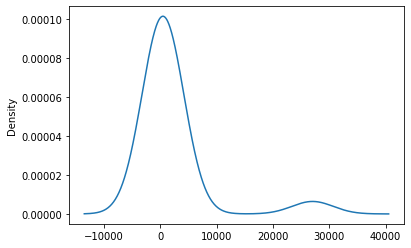

In [56]:
# Visualize the value counts of APPLICATION_TYPE
type_counts.plot.density()

In [57]:
# Determine which values to replace if counts are less than ...?
replace_application = list(type_counts[type_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [58]:
# Look at CLASSIFICATION value counts for binning
class_counts = application_df['CLASSIFICATION'].value_counts()
print(class_counts)

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64


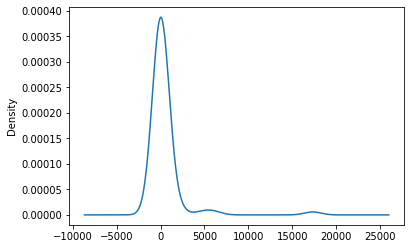

In [59]:
# Visualize the value counts of CLASSIFICATION
class_counts.plot.density()

In [60]:
# Determine which values to replace if counts are less than ..?
replace_class = list(class_counts[class_counts < 1883].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [61]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_df[application_cat].nunique()

APPLICATION_TYPE          9
AFFILIATION               6
CLASSIFICATION            6
USE_CASE                  5
ORGANIZATION              4
INCOME_AMT                9
SPECIAL_CONSIDERATIONS    2
dtype: int64

In [62]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [63]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [64]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Optimization attempt 1 - increase number of nodes

In [66]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 10
hidden_nodes_layer2 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features,activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 10)                440       
                                                                 
 dense_20 (Dense)            (None, 10)                110       
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [68]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 5629.4521 - accuracy: 0.4913
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 8740.2686 - accuracy: 0.5205
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 9059.8906 - accuracy: 0.4979
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 9753.7939 - accuracy: 0.5207
Epoch 5/100
804/804 [==============================] - 2s 2ms/step - loss: 5109.9795 - accuracy: 0.5210
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 1402.8707 - accuracy: 0.5264
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 851.6868 - accuracy: 0.5458
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 8834.0117 - accuracy: 0.5238
Epoch 9/100
804/804 [==============================] - 2s 2ms/step - loss: 1535.6201 - accuracy: 0.5290
Epoch 10/100
804/804 [==============================] - 2s 2ms/st

In [69]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 4.2747 - accuracy: 0.5364 - 436ms/epoch - 2ms/step
Loss: 4.274676322937012, Accuracy: 0.5364431738853455


#### Optimization attempt 2 - adding a third hidden layer

In [70]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5
hidden_nodes_layer3 = 5

nn2 = tf.keras.models.Sequential()

# First hidden layer
nn2.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features,activation="relu"))

# Second hidden layer
nn2.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation="relu"))

# Third hidden layer
nn2.add(tf.keras.layers.Dense(units=hidden_nodes_layer3,activation="relu"))

# Output layer
nn2.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# Check the structure of the model
nn2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 8)                 352       
                                                                 
 dense_23 (Dense)            (None, 5)                 45        
                                                                 
 dense_24 (Dense)            (None, 5)                 30        
                                                                 
 dense_25 (Dense)            (None, 1)                 6         
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Compile the model
nn2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [72]:
# Train the model
fit_model2 = nn2.fit(X_train,y_train,epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 17582.5352 - accuracy: 0.4782
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 20126.3320 - accuracy: 0.4940
Epoch 3/100
804/804 [==============================] - 1s 2ms/step - loss: 13415.8809 - accuracy: 0.5089
Epoch 4/100
804/804 [==============================] - 1s 2ms/step - loss: 12893.8643 - accuracy: 0.5087
Epoch 5/100
804/804 [==============================] - 2s 2ms/step - loss: 11914.1006 - accuracy: 0.4885
Epoch 6/100
804/804 [==============================] - 1s 2ms/step - loss: 11219.5693 - accuracy: 0.5167
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 7959.1025 - accuracy: 0.4996
Epoch 8/100
804/804 [==============================] - 1s 2ms/step - loss: 2292.6580 - accuracy: 0.4892
Epoch 9/100
804/804 [==============================] - 2s 2ms/step - loss: 777.3748 - accuracy: 0.5061
Epoch 10/100
804/804 [==============================] - 1s 

In [73]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6542 - accuracy: 0.5970 - 441ms/epoch - 2ms/step
Loss: 0.6541858911514282, Accuracy: 0.5969679355621338


#### Optimization attempt 3 - use different activation function

In [74]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

nn3 = tf.keras.models.Sequential()

# First hidden layer
nn3.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features,activation=tf.keras.layers.LeakyReLU()))

# Second hidden layer
nn3.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation=tf.keras.layers.LeakyReLU()))

# Output layer
nn3.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# Check the structure of the model
nn3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 8)                 352       
                                                                 
 dense_27 (Dense)            (None, 5)                 45        
                                                                 
 dense_28 (Dense)            (None, 1)                 6         
                                                                 
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Compile the model
nn3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [76]:
# Train the model
fit_model3 = nn3.fit(X_train,y_train,epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 11680.5010 - accuracy: 0.4944
Epoch 2/100
804/804 [==============================] - 1s 2ms/step - loss: 12987.3154 - accuracy: 0.5097
Epoch 3/100
804/804 [==============================] - 1s 2ms/step - loss: 1844.3038 - accuracy: 0.5034
Epoch 4/100
804/804 [==============================] - 1s 2ms/step - loss: 9316.5049 - accuracy: 0.5016
Epoch 5/100
804/804 [==============================] - 1s 2ms/step - loss: 4011.3176 - accuracy: 0.5178
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 1379.8408 - accuracy: 0.5548
Epoch 7/100
804/804 [==============================] - 1s 2ms/step - loss: 1689.3329 - accuracy: 0.5342
Epoch 8/100
804/804 [==============================] - 1s 2ms/step - loss: 7527.9814 - accuracy: 0.5284
Epoch 9/100
804/804 [==============================] - 1s 2ms/step - loss: 2056.1057 - accuracy: 0.4983
Epoch 10/100
804/804 [==============================] - 2s 2ms

In [77]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6886 - accuracy: 0.5292 - 483ms/epoch - 2ms/step
Loss: 0.6886197328567505, Accuracy: 0.5292128324508667


#### Optimization attempt 4 - combining more nodes with Leaky ReLU

In [78]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 10
hidden_nodes_layer2 = 10

nn4 = tf.keras.models.Sequential()

# First hidden layer
nn4.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features,activation=tf.keras.layers.LeakyReLU()))

# Second hidden layer
nn4.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation=tf.keras.layers.LeakyReLU()))

# Output layer
nn4.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# Check the structure of the model
nn4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 10)                440       
                                                                 
 dense_30 (Dense)            (None, 10)                110       
                                                                 
 dense_31 (Dense)            (None, 1)                 11        
                                                                 
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Compile the model
nn4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

In [80]:
# Train the model
fit_model4 = nn4.fit(X_train,y_train,epochs=100,callbacks=[cp_callback])

Epoch 1/100
797/804 [============================>.] - ETA: 0s - loss: 21903.2363 - accuracy: 0.4956
Epoch 1: saving model to checkpoints/weights.01.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 21785.1387 - accuracy: 0.4963
Epoch 2/100
796/804 [============================>.] - ETA: 0s - loss: 69312.3438 - accuracy: 0.4965
Epoch 2: saving model to checkpoints/weights.02.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 68751.0625 - accuracy: 0.4965
Epoch 3/100
782/804 [============================>.] - ETA: 0s - loss: 8814.4805 - accuracy: 0.5042
Epoch 3: saving model to checkpoints/weights.03.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 8576.8252 - accuracy: 0.5048
Epoch 4/100
799/804 [============================>.] - ETA: 0s - loss: 32434.7031 - accuracy: 0.5189
Epoch 4: saving model to checkpoints/weights.04.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 32238.4199 - accuracy: 0.5194
Epoch 5/100
78

In [81]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn4.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.7184 - accuracy: 0.5292 - 445ms/epoch - 2ms/step
Loss: 0.718410849571228, Accuracy: 0.5292128324508667


In [83]:
!pip install pyyaml h5py

In [82]:
nn4.save("AlphabetSoupCharity_Optimization.h5")